el conjunto de datos "Household Electric Power Consumption" de Kaggle. Este conjunto de datos contiene registros de consumo de energía en kilovatios-hora (kWh) a intervalos de un minuto.



**Generación de datos:**

Creamos un conjunto de datos sintético que simula el consumo de energía a lo largo del tiempo.

**Preprocesamiento:**

Normalizamos los datos y creamos un conjunto de datos adecuado para el modelo LSTM.

**Modelo LSTM: **

Construimos un modelo LSTM simple con capas LSTM y de abandono para prevenir el sobreajuste.

**Entrenamiento y predicción:**

Entrenamos el modelo y hacemos predicciones sobre el conjunto de prueba.

**Visualización:**

Mostramos los valores reales y predichos en un gráfico.

**Paso 1: Importar las librerías necesarias**
Asegúrate de tener las librerías necesarias instaladas:

In [8]:
pip install pandas numpy matplotlib scikit-learn keras


Luego, importa las librerías:

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


**Paso 2: Cargar el conjunto de datos**

Descarga el archivo CSV desde Kaggle y colócalo en el mismo directorio que tu script o notebook. Luego, carga el conjunto de datos:

In [10]:
# Cargar el conjunto de datos
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/household_power_consumption.txt', sep=';', low_memory=False,
                   parse_dates={'datetime': ['Date', 'Time']},
                   infer_datetime_format=True, na_values='?')

# Filtrar solo las columnas necesarias y eliminar filas con valores NaN
data = data[['datetime', 'Global_active_power']]
data.dropna(inplace=True)

# Convertir la columna de energía a tipo numérico
data['Global_active_power'] = data['Global_active_power'].astype(float)



<ipython-input-10-f19b40781c52>:2: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/household_power_consumption.txt', sep=';', low_memory=False,
<ipython-input-10-f19b40781c52>:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/household_power_consumption.txt', sep=';', low_memory=False,
<ipython-input-10-f19b40781c52>:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv('/content/drive/MyDrive/Colab No

**Paso 3: Preprocesar los datos**

Normalizamos los datos y creamos un conjunto de datos adecuado para el modelo LSTM.

In [11]:
# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Global_active_power'].values.reshape(-1, 1))

# Crear conjuntos de datos para entrenamiento y prueba
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

# Definir el número de pasos de tiempo
time_step = 10
X, y = create_dataset(scaled_data, time_step)

# Reshape para LSTM [muestras, pasos de tiempo, características]
X = X.reshape(X.shape[0], X.shape[1], 1)


**Paso 4: Dividir en conjuntos de entrenamiento y prueba**

In [12]:
# Dividir en conjuntos de entrenamiento y prueba
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


**Paso 5: Construir el modelo LSTM**

**LSTM:**

En la línea donde se define model.add(LSTM(...)), las funciones de activación sigmoide y tanh se aplican internamente en la implementación de Keras.

Las puertas (input gate, forget gate y output gate) utilizan la función sigmoide para determinar qué información retener o descartar.

La actualización de la celda y la salida utilizan la función tangente hiperbólica para generar los nuevos valores que se pasan a través de la red.

In [13]:
# Crear el modelo LSTM
model = Sequential()

# Capa LSTM con funciones sigmoide y tanh integradas en su funcionamiento
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))

# Función sigmoide y tanh aquí
model.add(Dropout(0.2))  # Capa de abandono para prevenir el sobreajuste

# Otra capa LSTM
model.add(LSTM(50, return_sequences=False))  # Función sigmoide y tanh aquí
model.add(Dropout(0.2))  # Capa de abandono

# Capa de salida
model.add(Dense(1))  # Capa densa para producir la salida

# Compilación del modelo
model.compile(optimizer='adam', loss='mean_squared_error')



**Paso 6: Entrenar el modelo**

In [14]:
# Entrenar el modelo
#model.fit(X_train, y_train, epochs=100, batch_size=32)
model.fit(X_train, y_train, epochs=3, batch_size=32)

Epoch 1/3
51232/51232 [==============================] - 477s 9ms/step - loss: 7.2058e-04
Epoch 2/3
51232/51232 [==============================] - 477s 9ms/step - loss: 6.8227e-04
Epoch 3/3
51232/51232 [==============================] - 478s 9ms/step - loss: 6.6384e-04


**Paso 7: Hacer predicciones**

La función inverse_transform se utiliza para revertir la normalización o escalado de los datos a su rango original. Esto es especialmente útil en el contexto de modelos de aprendizaje automático, donde los datos se normalizan antes de ser introducidos en el modelo para mejorar la convergencia y el rendimiento.

predicted_energy = scaler.inverse_transform(predicted_energy) utiliza el método inverse_transform del objeto scaler (que es una instancia de MinMaxScaler en este caso) para convertir las predicciones normalizadas de vuelta a su rango original. Esto permite que las predicciones se interpreten y se comparen con los valores reales de consumo de energía.

In [15]:
# Hacer predicciones
predicted_energy = model.predict(X_test)

# Invertir la normalización
predicted_energy = scaler.inverse_transform(predicted_energy)
actual_energy = scaler.inverse_transform(y_test.reshape(-1, 1))


12808/12808 [==============================] - 52s 4ms/step


**Paso 8: Visualizar los resultados**

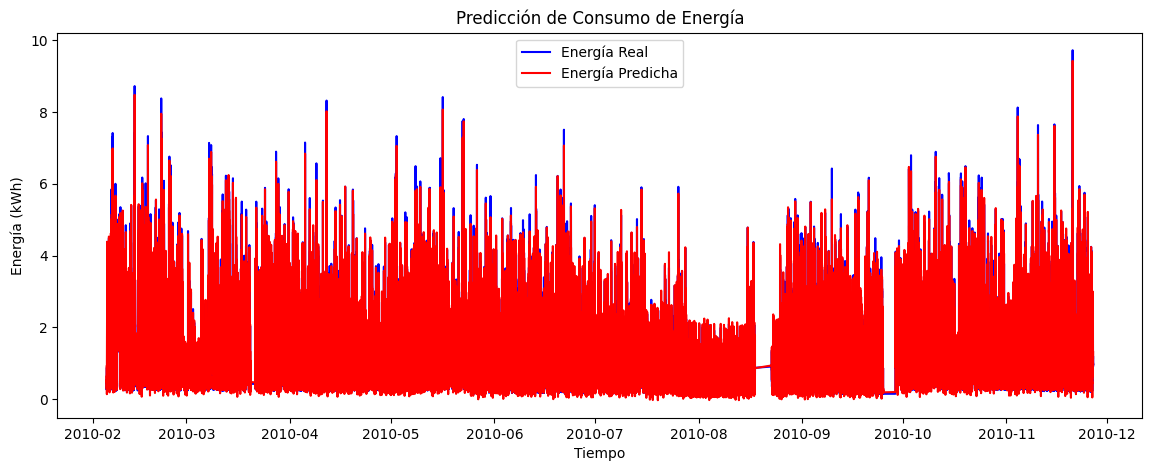

In [16]:
# Visualizar los resultados
plt.figure(figsize=(14, 5))
plt.plot(data['datetime'][len(data)-len(y_test):], actual_energy, color='blue', label='Energía Real')
plt.plot(data['datetime'][len(data)-len(y_test):], predicted_energy, color='red', label='Energía Predicha')
plt.title('Predicción de Consumo de Energía')
plt.xlabel('Tiempo')
plt.ylabel('Energía (kWh)')
plt.legend()
plt.show()


**Notas**

1. Formato de los datos:

Asegúrate de que el archivo household_power_consumption.txt esté correctamente formateado y que las columnas de fecha y hora se estén combinando correctamente.

2. Tiempo de entrenamiento:

Ajusta el número de épocas y el tamaño del lote según tu hardware y tus necesidades. Entrenar el modelo puede tardar un poco, especialmente si el conjunto de datos es grande.

3. Exploración de datos:

Antes de entrenar el modelo, puedes explorar el conjunto de datos para obtener información sobre su distribución y posibles valores atípicos.


**Personalizacion de Activaciones**

En este caso, activation='tanh' se utiliza para la activación de la celda, y recurrent_activation='sigmoid' se aplica para las puertas.

En este ejemplo, activation='tanh' se utiliza para la activación de la celda, lo que permite que la red maneje tanto la información positiva como la negativa, mientras que recurrent_activation='sigmoid' se utiliza para controlar cómo se gestionan las puertas.




In [17]:
model.add(LSTM(50, return_sequences=True, activation='tanh', recurrent_activation='sigmoid', input_shape=(X_train.shape[1], 1)))


ValueError: Input 0 of layer "lstm_5" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 1)